# Comparison of internal recirculation for dimpled ellipsoidal and skirted bubbles

## Dependencies

Notebooks (links work only if the Docker container is running)

- [process_logs.ipynb](http://127.0.0.1:8888/notebooks/process_logs.ipynb)

Raw data

- ../data/bhaga_03_l16/bhaga_03_l16_t30.csv
- ../data/bhaga_04_l16/bhaga_04_l16_t20.csv
- ../data/bhaga_02_l16/bhaga_02_l16_of_flow_pyto.csv
- ../data/bhaga_04_l16/bhaga_04_l16_of_flow_pyto.csv
- ../data/bhaga_02_l16/bhaga_02_l16_of_flow_slip.csv
- ../data/bhaga_04_l16/bhaga_04_l16_of_flow_slip.csv

To see how the data was extracted from Basilisk simulations, refer to the notebook [basilisk_2D_velocity_field.ipynb](http://127.0.0.1:8888/notebooks/basilisk_2D_velocity_field.ipynb). The setups for the OpenFOAM simulations are available [here](https://github.com/AndreWeiner/phd_openfoam/tree/master/test_cases/simpleFoam).

## Read fields from Basilisk and OpenFOAM simulations

In [1]:
import helper_module as hm

# Basilisk names amd simulation times
names = ["bhaga_02_l16", "bhaga_04_l16"]
times = [30, 20]

data_path = "../data/"
cases = [data_path + name for name in names]
print(cases)

['../data/bhaga_02_l16', '../data/bhaga_04_l16']


In [2]:
basilisk = {}
of_pyto = {}
of_slip = {}
U_b = []

for i, case in enumerate(cases):
    case_name = case.split("/")[-1]
    log_path = case + "/log." + case_name + ".csv"
    log = hm.Logfile(log_path)
    log.read_logfile(usecols=['time', 'u_x', 'x'])
    row = log.find_closest("time", times[i])
    U_b.append(row.u_x.values[0])
    field_path = case + "/" + case_name + "_t{:2d}.csv".format(times[i])
    basilisk[case_name] = hm.CenterFieldValues2D(field_path, [0.0, row.x.values[0]], [0.0, row.u_x.values[0]])
    field_path = case + "/" + case_name + "_of_flow_pyto.csv"
    of_pyto[case_name] = hm.CenterFieldValues2D(field_path, [0.0, 0.0], [0.0, 0.0], True)
    field_path = case + "/" + case_name + "_of_flow_slip.csv"
    of_slip[case_name] = hm.CenterFieldValues2D(field_path, [0.0, 0.0], [0.0, 0.0], True)
    
print("Rise velocities:\n", U_b)

Successfully read file ../data/bhaga_02_l16/log.bhaga_02_l16.csv
Successfully read file ../data/bhaga_02_l16/bhaga_02_l16_t30.csv
Successfully read file ../data/bhaga_02_l16/bhaga_02_l16_of_flow_pyto.csv
Successfully read file ../data/bhaga_02_l16/bhaga_02_l16_of_flow_slip.csv
Successfully read file ../data/bhaga_04_l16/log.bhaga_04_l16.csv
Successfully read file ../data/bhaga_04_l16/bhaga_04_l16_t20.csv
Successfully read file ../data/bhaga_04_l16/bhaga_04_l16_of_flow_pyto.csv
Successfully read file ../data/bhaga_04_l16/bhaga_04_l16_of_flow_slip.csv
Rise velocities:
 [0.54874959000000001, 0.63062704000000003]


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
rc('text', usetex=True)

bbox = dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5')

output_path = "../output/"

def savefig(name):
    plt.savefig(output_path + name + ".png", bbox_inches="tight")
    plt.savefig(output_path + name + ".pdf", bbox_inches="tight")

## Plot streamlines

In [16]:
def get_mesh(x_max, y_min, y_max, nx, ny):
    xi = np.linspace(0.0, x_max, nx)
    yi = np.linspace(y_min, y_max, ny)
    Xi, Yi = np.meshgrid(xi, yi)
    return xi, yi, Xi, Yi

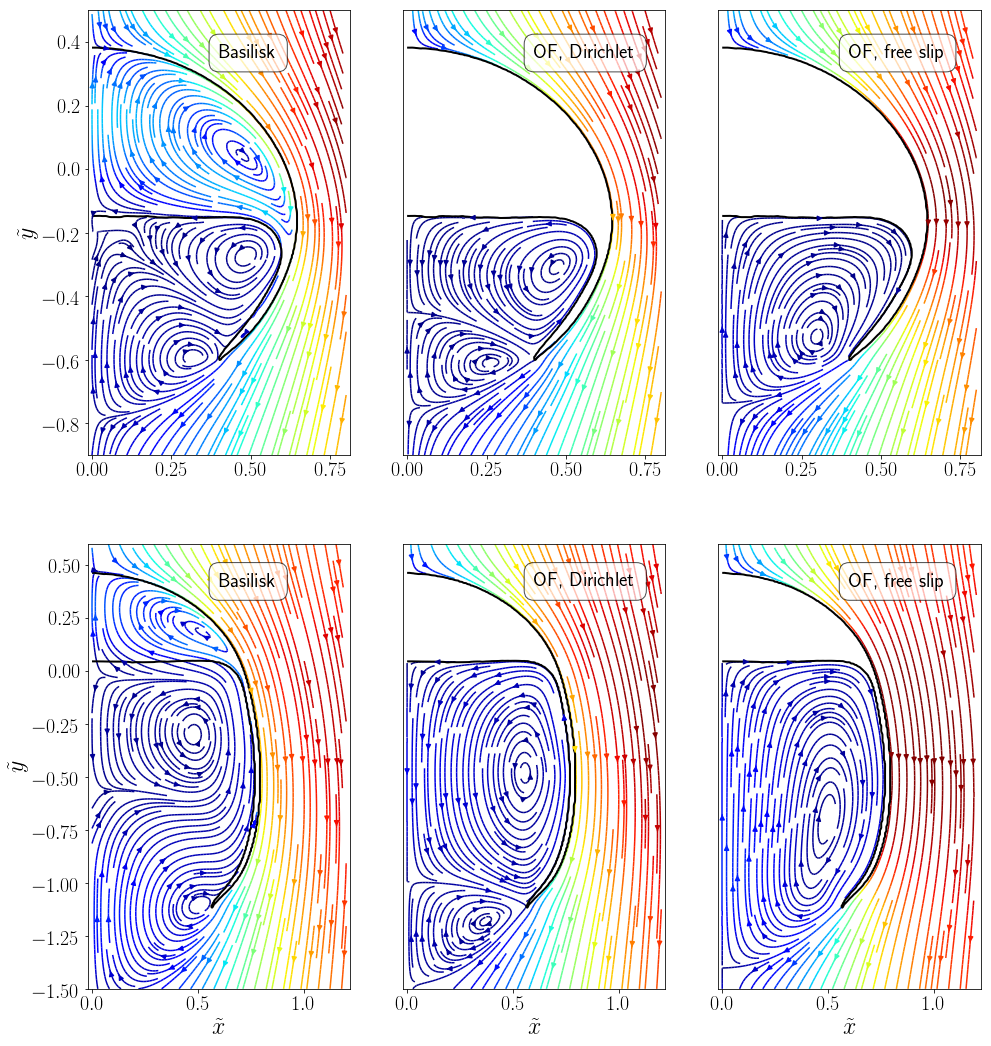

In [42]:
fig, axarr = plt.subplots(2, 3, figsize=(hm.figure_width, 18))

y_min = [-0.9, -1.5]
y_max = [0.5, 0.6]
x_max = [0.8, 0.8 * (y_max[1] - y_min[1]) / (y_max[0] - y_min[0])]
nx = [200, 200]
ny = [int(nx[i] * (y_max[i] - y_min[i]) / x_max[i]) for i in range(len(nx))]
labels = ["Basilisk", "OF, Dirichlet", "OF, free slip"]

for i, case in enumerate(cases):
    case_name = case.split("/")[-1]
    xi, yi, Xi, Yi = get_mesh(x_max[i], y_min[i], y_max[i], nx[i], ny[i])
    vol_f =  basilisk[case_name].interpolate_volume_fraction(Xi, Yi)
    vol_f_mask = np.where(vol_f < 0.5, 0, 1.0)
    axarr[i, 0].set_ylabel(r"$\tilde{y}$", fontsize=hm.fontsize_label)
    for j, field in enumerate([basilisk[case_name], of_pyto[case_name], of_slip[case_name]]):
        mag_U = field.interpolate_velocity(Xi, Yi, True, True)
        if j is 0:
            U_x, U_y = field.interpolate_velocity(Xi, Yi, True, False)
        else:
            U_y, U_x = field.interpolate_velocity(Xi, Yi, True, False)
            U_y *= vol_f_mask
            U_x *= vol_f_mask
        axarr[i, j].streamplot(Xi, Yi, U_x, U_y, color=mag_U/U_b[i],
                               cmap='jet', density=(1.5, 3.0), minlength=0.1, maxlength=8.0)
        axarr[i, j].contour(xi, yi, vol_f, levels=[0.5], colors=['k'], linewidths=2.0)
        axarr[i, j].axis('equal')
        axarr[i, j].tick_params(labelsize=hm.fontsize_tick)
        axarr[i, j].set_xlim(0.0, x_max[i])
        axarr[i, j].set_ylim(y_min[i], y_max[i])
        if j > 0: axarr[i,j].set_yticks([])
        axarr[1, j].set_xlabel(r"$\tilde{x}$", fontsize=hm.fontsize_label)
        if i is 0:
            axarr[i, j].text(0.4, 0.35, labels[j], fontsize=hm.fontsize_legend, bbox=bbox)
        else:
            axarr[i, j].text(0.6, 0.4, labels[j], fontsize=hm.fontsize_legend, bbox=bbox)
savefig("of_vs_basilisk_streamlines")